# Introduction

According to the CDC, more than 48 million Americans per year become sick from food, and an estimated 75% of the outbreaks came from food prepared by caterers, delis, and restaurants. In most cities, health inspections are generally random, which can increase time spent on spot checks at clean restaurants that have been following the rules closely — and missed opportunities to improve health and hygiene at places with more pressing food safety issues.

The goal for this project is to leverage public citizen generated data from social media to narrow the search for critical health and safety violations in New York City. As the City of New York manages  an open data portal, everyone can access historical hygiene inspections and violation records. By combine these two data source this project aims to determine which words, phrases, ratings, and patterns among restaurants lead to critical health and safety violations. This model can assist city health inspectors do their job better by prioritizing the kitchens most likely to be in violation of code.

The New York Health Department inspects the approximately 27,000 restaurants within the city to monitor their compliance with food safety regulations. Inspectors observe how food is prepared, served and stored and whether restaurant workers are practicing good hygiene. They check food temperatures, equipment maintenance and pest control measures.

### Imports

In [256]:
from IPython import display
from bs4 import BeautifulSoup as bs
import requests
import json
from sodapy import Socrata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
import time

import glob, os

call_apis = False
warnings.filterwarnings("ignore")
pd.set_option('display.max_colwidth',100)
pd.set_option('display.max_columns',50)
pd.options.display.float_format = '{:.2f}'.format

from sklearn.preprocessing import OneHotEncoder


# Obtain

This project requires data pulled from two different sources, the City of New York and Yelp. To obtain the data we will call the API keys.

 > The dataset contains every sustained or not yet adjudicated violation citation from every full or special program inspection conducted up to three years prior to the most recent inspection for restaurants and college cafeterias in an active status on the RECORD DATE (date of the data pull). When an inspection results in more than one violation, values for associated fields are repeated for each additional violation record. Establishments are uniquely identified by their CAMIS (record ID) number. Keep in mind that thousands of restaurants start business and go out of business every year; only restaurants in an active status are included in the dataset.
Records are also included for each restaurant that has applied for a permit but has not yet been inspected and for inspections resulting in no violations. Establishments with inspection date of 1/1/1900 are new establishments that have not yet received an inspection. Restaurants that received no violations are represented by a single row and coded as having no violations using the ACTION field.
Because this dataset is compiled from several large administrative data systems, it contains some illogical values that could be a result of data entry or transfer errors. Data may also be missing.
This dataset and the information on the Health Department’s Restaurant Grading website come from the same data source. The Health Department’s Restaurant Grading website is here:
http://www1.nyc.gov/site/doh/services/restaurant-grades.page

> Why does the Health Department inspect restaurants?
The Health Department inspects the approximately 27,000 restaurants in New York City to monitor their compliance with food safety regulations. Inspectors observe how food is prepared, served and stored and whether restaurant workers are practicing good hygiene. They check food temperatures, equipment maintenance and pest control measures.

> Since 2010, New York City has required restaurants to post letter grades that correspond to scores received from sanitary inspections. An inspection score of 0 to 13 is an A, 14 to 27 points is a B, and 28 or more points is a C. Grade cards must be posted where they can easily be seen by people passing by.

> The New York City Health Department inspects all food service establishments to make sure they meet Health Code requirements, which helps prevent
foodborne illness. How often a restaurant is inspected depends on its inspection score. Restaurants that receive a low score on the initial or first inspection
in the inspection cycle are inspected less often than those that receive a high score.

> The points for a particular violation depend on the health risk it poses to the public. Violations fall into three categories:
>* A public health hazard, such as failing to keep food at the right temperature, triggers a minimum of 7 points. If the violation can’t be corrected before the inspection ends, the Health Department may close the restaurant until it’s fixed.
>* A critical violation, for example, serving raw food such as a salad without properly washing it first, carries a minimum of 5 points.
>* A general violation, such as not properly sanitizing
cooking utensils, receives at least 2 points.

>Inspectors assign additional points to reflect the extent of the
violation. A violation’s condition level can range from 1 (least
extensive) to 5 (most extensive). For example, the presence of
one contaminated food item is a condition level 1 violation,
generating 7 points. Four or more contaminated food items
is a condition level 4 violation, resulting in 10 points. 

> How are restaurants graded?
Violations found during inspections carry point values, and a restaurant’s score corresponds to a letter grade. The point/grade cut-offs are the same as for mobile food vending letter grading, with fewer points corresponding to a better grade:

>* "A" grade: 0 to 13 points for sanitary violations
>* "B" grade: 14 to 27 points for sanitary violations
>* "C" grade: 28 or more points for sanitary violations


The City of New York inspects all restaurants cyclically. And if a business does not pass it's initial inspection for the cycle, it will be re-inspected in 3-5 months.

## Obtaining Restaurant Inspection Results from NYC Open Data Portal

The dataset can be obtained here

https://data.cityofnewyork.us/Health/DOHMH-New-York-City-Restaurant-Inspection-Results/43nn-pn8j

The dataset was downloaded and saved to this repository. Let's load it in and explore its contents.

Detailed descriptions about each column can be found in the Restaurant Inspection Data Dictionary.

In [107]:
doh_df = pd.read_csv('data/nyc_open_data/DOHMH_New_York_City_Restaurant_Inspection_Results.csv')
doh_df

,CAMIS,DBA,BORO,BUILDING,STREET,ZIPCODE,PHONE,CUISINE DESCRIPTION,INSPECTION DATE,ACTION,VIOLATION CODE,VIOLATION DESCRIPTION,CRITICAL FLAG,SCORE,GRADE,GRADE DATE,RECORD DATE,INSPECTION TYPE,Latitude,Longitude,Community Board,Council District,Census Tract,BIN,BBL,NTA
0,50008319,POULETTE,Manhattan,790,9 AVENUE,10019.00,2129569488,Chicken,01/28/2019,Violations were cited in the following area(s).,04D,"Food worker does not wash hands thoroughly after using the toilet, coughing, sneezing, smoking, ...",Critical,22,NaN,NaN,03/24/2022,Cycle Inspection / Initial Inspection,40.77,-73.99,104.00,3.00,13300.00,1025235.00,1010430004.00,MN15
1,41678734,TINY'S DINER,Bronx,3603,RIVERDALE AVENUE,10463.00,7187087600,American,09/23/2019,Violations were cited in the following area(s).,04M,Live roaches present in facility's food and/or non-food areas.,Critical,24,NaN,NaN,03/24/2022,Cycle Inspection / Initial Inspection,40.89,-73.91,208.00,11.00,29500.00,2084186.00,2057960167.00,BX29
2,40795021,TAO RESTAURANT,Manhattan,42,EAST 58 STREET,10022.00,2128882288,Asian/Asian Fusion,03/11/2020,Violations were cited in the following area(s).,10F,Non-food contact surface improperly constructed. Unacceptable material used. Non-food contact su...,Not Critical,9,NaN,NaN,03/24/2022,Cycle Inspection / Initial Inspection,40.76,-73.97,105.00,4.00,11202.00,1036073.00,1012930047.00,MN17
3,40795021,TAO RESTAURANT,Manhattan,42,EAST 58 STREET,10022.00,2128882288,Asian/Asian Fusion,03/11/2020,Violations were cited in the following area(s).,10F,Non-food contact surface improperly constructed. Unacceptable material used. Non-food contact su...,Not Critical,9,NaN,NaN,03/24/2022,Cycle Inspection / Initial Inspection,40.76,-73.97,105.00,4.00,11202.00,1036073.00,1012930047.00,MN17
4,40538234,"DUNKIN',' BASKIN ROBBINS",Queens,9925,HORACE HARDING EXPRESSWAY,11368.00,7182719222,Donuts,07/29/2021,Violations were cited in the following area(s).,06E,"Sanitized equipment or utensil, including in-use food dispensing utensil, improperly used or sto...",Critical,10,A,07/29/2021,03/24/2022,Cycle Inspection / Initial Inspection,40.74,-73.86,404.00,21.00,43702.00,4047915.00,4019480019.00,QN25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186222,41556790,FIVE GUYS FAMOUS BURGERS AND FRIES,Manhattan,2847,BROADFWAY,nan,2126787701,Hamburgers,03/01/2019,Violations were cited in the following area(s).,10F,Non-food contact surface improperly constructed. Unacceptable material used. Non-food contact su...,Not Critical,3,A,03/01/2019,03/24/2022,Cycle Inspection / Initial Inspection,0.00,0.00,nan,nan,nan,nan,1.00,NaN
186223,50032876,TANNER SMITH'S,Manhattan,204,WEST 55 STREET,10019.00,9175172283,American,06/07/2019,Violations were cited in the following area(s).,08A,Facility not vermin proof. Harborage or conditions conducive to attracting vermin to the premise...,Not Critical,12,A,06/07/2019,03/24/2022,Cycle Inspection / Initial Inspection,40.76,-73.98,105.00,4.00,13700.00,1024857.00,1010260037.00,MN17
186224,50003842,T- 45,Manhattan,135,WEST 45 STREET,10036.00,6466403775,American,07/26/2018,Violations were cited in the following area(s).,10B,Plumbing not properly installed or maintained; anti-siphonage or backflow prevention device not ...,Not Critical,49,NaN,NaN,03/24/2022,Cycle Inspection / Initial Inspection,40.76,-73.98,105.00,4.00,11900.00,1089796.00,1009980015.00,MN17
186225,41640824,RICURAS ECUADORIAN BAKERY,Bronx,1576,WATSON AVENUE,10472.00,7184508363,Spanish,07/20/2018,Violations were cited in the following area(s).,06F,Wiping cloths soiled or not stored in sanitizing solution.,Critical,12,A,07/20/2018,03/24/2022,Cycle Inspection / Initial Inspection,40.83,-73.88,209.00,18.00,5001.00,2023533.00,2037160036.00,BX55


The dataset contains 186,227 inspection results. However, when an inspection results in more than one violation, values for associated fields are repeated for each additional violation record. So let's check how many individual restaurants are in the dataset.

### Understanding NYC DOHMH Data

In [108]:
# How many unique restaurants are in this dataset?
n_unique = doh_df['CAMIS'].nunique()
print(f'There are {n_unique} unique restaurants in the dataset. ')

There are 19792 unique restaurants in the dataset. 


In [109]:
# Get more information about the dataset contents
doh_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186227 entries, 0 to 186226
Data columns (total 26 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   CAMIS                  186227 non-null  int64  
 1   DBA                    186200 non-null  object 
 2   BORO                   186227 non-null  object 
 3   BUILDING               185799 non-null  object 
 4   STREET                 186227 non-null  object 
 5   ZIPCODE                183146 non-null  float64
 6   PHONE                  186214 non-null  object 
 7   CUISINE DESCRIPTION    186226 non-null  object 
 8   INSPECTION DATE        186227 non-null  object 
 9   ACTION                 186227 non-null  object 
 10  VIOLATION CODE         185413 non-null  object 
 11  VIOLATION DESCRIPTION  185863 non-null  object 
 12  CRITICAL FLAG          186227 non-null  object 
 13  SCORE                  186227 non-null  int64  
 14  GRADE                  67933 non-nul

In [205]:
doh_df['ZIPCODE'].astype(str)

0         10019.0
1         10463.0
2         10022.0
4         11368.0
5         10013.0
           ...   
186221        nan
186223    10019.0
186224    10036.0
186225    10472.0
186226    10461.0
Name: ZIPCODE, Length: 174712, dtype: object

In [206]:
doh_df['Community Board'].astype(str)

0         104.0
1         208.0
2         105.0
4         404.0
5         101.0
          ...  
186221      nan
186223    105.0
186224    105.0
186225    209.0
186226    210.0
Name: Community Board, Length: 174712, dtype: object

In [207]:
doh_df['Council District'].astype(str)

0          3.0
1         11.0
2          4.0
4         21.0
5          1.0
          ... 
186221     nan
186223     4.0
186224     4.0
186225    18.0
186226    13.0
Name: Council District, Length: 174712, dtype: object

In [208]:
doh_df['Census Tract'].astype(str)

0         13300.0
1         29500.0
2         11202.0
4         43702.0
5          2100.0
           ...   
186221        nan
186223    13700.0
186224    11900.0
186225     5001.0
186226    30000.0
Name: Census Tract, Length: 174712, dtype: object

Every row has a restaurant ID, address, date, and score. Let's ensure there aren't any duplicated rows.

In [110]:
print(f'There are {doh_df.duplicated(keep=False).sum()} duplicated rows. ')

There are 22010 duplicated rows. 


In [111]:
# Let's drop these duplucated rows
doh_df.drop_duplicates(keep='first',inplace=True)

In [112]:
# Confirming duplicates have been removed
doh_df.shape

(174725, 26)

Since this project will be leveraging data publicly generated from social media a lookup value will be needed to call the API and join the tables. The Yelp API has an endpoint for Phone Search. This will allow us to pull Yelp business data for each restaurant by proivinging a telephone number. More infomration can be found in the [documentation here.](https://www.yelp.com/developers/documentation/v3/business_search_phone)

In [113]:
# Checking that every restaunt has a phone number
missing_num = doh_df['PHONE'].isna().sum()
print(f'There are {missing_num} restaunts missing a telephone number.')

There are 13 restaunts missing a telephone number.


In [114]:
# Since only 13 numbers are missing, these rows can be dropped
doh_df.dropna(subset=['PHONE'],inplace=True)

In [115]:
# Confirming records were dropped
doh_df['PHONE'].isna().sum()

0

In [116]:
# How many unique restaurants are remaining?
n_unique = doh_df['CAMIS'].nunique()
print(f'There are {n_unique} unique restaurants remaining in the dataset. ')

There are 19790 unique restaurants remaining in the dataset. 


Let's explore the date range for this dataset.

In [117]:
doh_df['INSPECTION DATE'] =  pd.to_datetime(doh_df['INSPECTION DATE'])
begin_date = doh_df['INSPECTION DATE'].min()
end_date = doh_df['INSPECTION DATE'].max()
print(f'The data ranges from {begin_date} to {end_date}')

The data ranges from 2009-05-16 00:00:00 to 2022-03-23 00:00:00


Inspections in this dataset range from May 2009 up to March 2022.

### Target Variable -- NYCDOH Inspection Grades

Health code violations found during an inspections carries a point value, and a restaurant’s score corresponds to a letter grade. A lower point score, leads to a better letter grade:

* "A" grade: 0 to 13 points for sanitary violations
* "B" grade: 14 to 27 points for sanitary violations
* "C" grade: 28 or more points for sanitary violations

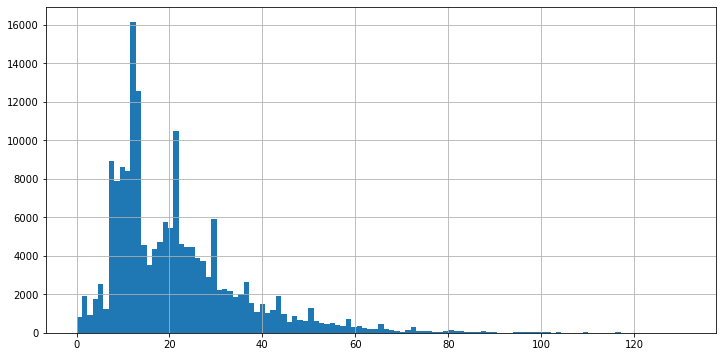

In [118]:
# Let see what the score distribution is
doh_df['SCORE'].hist(bins=113, figsize=(12,6));

In [217]:
doh_df['SCORE'].describe()

count   174712.00
mean        21.36
std         14.36
min          0.00
25%         12.00
50%         18.00
75%         27.00
max        131.00
Name: SCORE, dtype: float64

In [218]:
doh_graded = doh_df.copy()

In [185]:
doh_graded.drop(columns=['INSPECTION DATE', 'ACTION', 'VIOLATION CODE',
       'VIOLATION DESCRIPTION', 'CRITICAL FLAG','GRADE',
       'GRADE DATE', 'RECORD DATE', 'INSPECTION TYPE'],inplace=True)

In [223]:
doh_graded['A'] = (doh_graded['SCORE'] < 14).astype(int)
doh_graded['B'] = (doh_graded['SCORE'] > 13).astype(int) & (doh_df['SCORE'] < 28).astype(int)
doh_graded['C'] = (doh_graded['SCORE'] > 27).astype(int)

In [232]:
doh_grouped = doh_graded.groupby(by=['CAMIS', 'DBA','CUISINE DESCRIPTION',
                                     'BORO', 'BUILDING',
                                     'STREET', 'ZIPCODE', 'PHONE', 'Latitude',
                                     'Longitude', 'Community Board',
                                     'Council District','Census Tract'],dropna=False)['A','B','C'].sum()

In [233]:
(doh_grouped['B'] > 0).sum()

9977

Of the 19,790 unique restaurants, 9,977 failed an initial cycle inspection at least once.

In [234]:
(doh_grouped['C'] > 0).sum()

5648

Of the 19,790 unique restaurants, 5,648 severly failed an initial cycle inspection at least once and are at risk of being closed by the DOHMH.

In [235]:
# Creating the Target Variable 'Severe' for Restaurants that have scored over 28 points in an initial inspection.
doh_grouped['Severe'] = (doh_grouped['C'] > 0).astype(int)

In [236]:
nyc_doh = doh_grouped.reset_index()
nyc_doh.drop(['A','B','C'],axis=1, inplace=True)
nyc_doh

,CAMIS,DBA,CUISINE DESCRIPTION,BORO,BUILDING,STREET,ZIPCODE,PHONE,Latitude,Longitude,Community Board,Council District,Census Tract,Severe
0,30075445,MORRIS PARK BAKE SHOP,Bakery Products/Desserts,Bronx,1007,MORRIS PARK AVENUE,10462.00,7188924968,40.85,-73.86,211.00,13.00,25200.00,0
1,30112340,WENDY'S,Hamburgers,Brooklyn,469,FLATBUSH AVENUE,11225.00,7182875005,40.66,-73.96,309.00,40.00,32700.00,0
2,30191841,DJ REYNOLDS PUB AND RESTAURANT,Irish,Manhattan,351,WEST 57 STREET,10019.00,2122452912,40.77,-73.98,104.00,3.00,13900.00,0
3,40356018,RIVIERA CATERERS,American,Brooklyn,2780,STILLWELL AVENUE,11224.00,7183723031,40.58,-73.98,313.00,47.00,34800.00,0
4,40356483,WILKEN'S FINE FOOD,Sandwiches,Brooklyn,7114,AVENUE U,11234.00,7184443838,40.62,-73.91,318.00,46.00,70000.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19785,50115169,Sobak,Korean,Manhattan,51,CANAL STREET,10002.00,9294018597,40.71,-73.99,103.00,1.00,1600.00,0
19786,50116155,SEPTEMBER,Coffee/Tea,Brooklyn,83,SARATOGA AVENUE,11233.00,5086491703,40.68,-73.92,316.00,41.00,37300.00,0
19787,50117350,SONG TEA,Coffee/Tea,Manhattan,488,7 AVENUE,10018.00,6466697802,40.75,-73.99,105.00,3.00,10900.00,0
19788,50117434,LA POLLERA COLORADA,Spanish,Queens,8213,NORTHERN BLVD,11372.00,7184246531,40.76,-73.89,403.00,25.00,32700.00,1


#### NYC DOH Data Exploration

In [194]:
nyc_doh['BORO'].value_counts()

Manhattan        7892
Brooklyn         4801
Queens           4468
Bronx            1920
Staten Island     704
0                   5
Name: BORO, dtype: int64

In [195]:
nyc_doh['CUISINE DESCRIPTION'].value_counts()

American             4269
Chinese              1716
Coffee/Tea           1316
Pizza                1249
Italian               829
                     ... 
Czech                   3
Fruits/Vegetables       2
Chilean                 1
Basque                  1
Fusion                  1
Name: CUISINE DESCRIPTION, Length: 84, dtype: int64

In [201]:
nyc_doh['ZIPCODE'].value_counts()

10019.00    513
10036.00    469
10003.00    463
10001.00    367
10022.00    359
           ... 
10177.00      1
10173.00      1
10170.00      1
10171.00      1
10069.00      1
Name: ZIPCODE, Length: 221, dtype: int64

## Obtaining Yelp Buniness and Review Data

Now that we have an understanding of the city's inspection results and have explored that dataset it is time to pull in data from the crowd-sourced review platform Yelp.

In [237]:
# Loading in locally stored API credentials. 
# You can sign up for access and obtain credentials to the Yelp API here: 
# https://www.yelp.com/developers/documentation/v3

with open('/Users/Rob/.secret/yelp_api.json') as f:
    creds = json.load(f)

In [238]:
# Checking creds were properly loaded in
creds.keys()

dict_keys(['api_key'])

### Yelp Business Search

In [244]:
# Formatting phone numbers provided in the NYCDOH dataset 
nyc_doh['PHONE'] = '+1'+nyc_doh['PHONE']
# Ensure the list contains unique phone numbers only
phone_numbers = set(nyc_doh['PHONE'])
phone_numbers = list(phone_numbers)
number_count = len(phone_numbers)
print(f'There are {number_count} unique phone numbers.')

There are 18937 unique phone numbers.


So we will call the Yelp API at the Phone Search Endpoint for all the numbers in the `phone_numbers` list. However the API only allows 5000 callers per day so we'll slice the list into smaller list.

In [245]:
# Slicing the phone list into smaller list to fit under the API daily limit restrictions
phone_numbers1 = phone_numbers[1:1000]
phone_numbers2 = phone_numbers[1000:2000]
phone_numbers3 = phone_numbers[2000:2500]
phone_numbers4 = phone_numbers[2500:3500]
phone_numbers5 = phone_numbers[3500:5000]
phone_numbers6 = phone_numbers[5000:6000]
phone_numbers7 = phone_numbers[6000:7500]
phone_numbers8 = phone_numbers[7500:10000]
phone_numbers9 = phone_numbers[10000:12500]
phone_numbers11 = phone_numbers[15000:17500]
phone_numbers12 = phone_numbers[17500:20000]
phone_numbers9 = phone_numbers[10000:12500]
phone_numbers10 = phone_numbers[12500:15000]
phone_numbers11 = phone_numbers[15000:17500]
phone_numbers12 = phone_numbers[17500:19000]

In [249]:
#Functionizing the Yelp API Phone Search

def get_businesses(phone_numbers):
    """Input a list of formatted phone numbers
    (must start with + and include the country code, like +14159083801)
    and returns a corresponding list of Yelp Businesses"""
    
    biz_list = []
    
    for number in phone_numbers:
        url = 'https://api.yelp.com/v3/businesses/search/phone'
        headers = {'Authorization': 'Bearer ' + creds['api_key']}
        url_params = {'phone': number}
        response = requests.get(url, headers=headers, params=url_params)
        response_json = response.json()
        biz_list.extend(response_json.get('businesses','U'))
        
    while 'U' in biz_list:
        biz_list.remove('U')
        
    return biz_list

In [261]:
# Call `get_business` function
if call_apis == True:
    biz_list12 = get_businesses(phone_numbers12)
    
    # Save returned list as a DataFrame and .csv file
    biz12_df = pd.DataFrame(biz_list12)
    biz12_df.to_csv('data/yelp_data/yelp_business/yelp_phone12.csv',index=False)

In [315]:
# List of files containing Yelp business data
fpath = 'data/yelp_data/yelp_businesses/'
os.listdir(fpath)
query = fpath+"*.csv"
f_list = glob.glob(query)

In [326]:
# Append saved Yelp Business tables to a dict
yelp_tables = {}

for f in f_list:
    temp_df = pd.read_csv(f)
    fname = file.replace('data/yelp_data/yelp_businesses/yelp_phone','df_').replace('.csv','')
    yelp_tables[fname] = temp_df

In [335]:
yelp_df_list = [t for t in list(yelp_tables.keys())]

In [337]:
# Concatenating all Yelp Businesses responses from the Phone Search
yelp_businesses_df = pd.concat(yelp_tables,ignore_index=True)
yelp_businesses_df

,id,alias,name,image_url,is_closed,url,review_count,categories,rating,coordinates,transactions,price,location,phone,display_phone
0,RzKR9QcYP03EQ_8DxTxowg,barrio-chino-new-york,Barrio Chino,https://s3-media0.fl.yelpcdn.com/bphoto/dpaRqPZD6xqDZo2ZfOyjnQ/o.jpg,False,https://www.yelp.com/biz/barrio-chino-new-york?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campai...,1148,"[{'alias': 'mexican', 'title': 'Mexican'}, {'alias': 'bars', 'title': 'Bars'}]",4.00,"{'latitude': 40.718022, 'longitude': -73.990026}","['delivery', 'pickup']",$$,"{'address1': '253 Broome St', 'address2': None, 'address3': '', 'city': 'New York', 'zip_code': ...",12122286710,(212) 228-6710
1,hrP3xLWJ8sLwG_XxEGq61Q,reyes-restaurant-woodside,Reyes Restaurant,https://s3-media0.fl.yelpcdn.com/bphoto/_dwQGccROJaxa-oNIxQsEg/o.jpg,False,https://www.yelp.com/biz/reyes-restaurant-woodside?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_ca...,7,"[{'alias': 'latin', 'title': 'Latin American'}, {'alias': 'dominican', 'title': 'Dominican'}]",4.00,"{'latitude': 40.7466, 'longitude': -73.9098}",['delivery'],$,"{'address1': '4754 46th St', 'address2': '', 'address3': '', 'city': 'Woodside', 'zip_code': '11...",17187529577,(718) 752-9577
2,in7QM4vNUTHVZIi7Outetg,mcdonalds-new-york-430,McDonald's,https://s3-media0.fl.yelpcdn.com/bphoto/bNmu8D1sjwJzbxxP9ZwJOQ/o.jpg,False,https://www.yelp.com/biz/mcdonalds-new-york-430?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_campa...,103,"[{'alias': 'burgers', 'title': 'Burgers'}, {'alias': 'hotdogs', 'title': 'Fast Food'}, {'alias':...",1.50,"{'latitude': 40.7163213865248, 'longitude': -74.0106988300204}",['delivery'],$,"{'address1': '167 Chambers St', 'address2': '', 'address3': '', 'city': 'New York', 'zip_code': ...",12126082405,(212) 608-2405
3,F-YGKegXRG2TE-Xw1AWeCA,popeyes-louisiana-kitchen-rockaway-beach-2,Popeyes Louisiana Kitchen,https://s3-media0.fl.yelpcdn.com/bphoto/A4MR2hDN3mWefMUT7bBB2A/o.jpg,False,https://www.yelp.com/biz/popeyes-louisiana-kitchen-rockaway-beach-2?adjust_creative=82uXkAt1Tiw7...,21,"[{'alias': 'hotdogs', 'title': 'Fast Food'}, {'alias': 'seafood', 'title': 'Seafood'}, {'alias':...",2.00,"{'latitude': 40.587551867915515, 'longitude': -73.81088484629929}","['pickup', 'delivery']",$,"{'address1': '8601 Rockaway Beach Blvd', 'address2': '', 'address3': None, 'city': 'Rockaway Bea...",17189452815,(718) 945-2815
4,rYl_R-UILYqA6vYsbNwLsg,joe-coffee-company-new-york-14,Joe Coffee Company,https://s3-media0.fl.yelpcdn.com/bphoto/e-nX3g-MQAN48MDPAv2cIg/o.jpg,False,https://www.yelp.com/biz/joe-coffee-company-new-york-14?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&u...,24,"[{'alias': 'coffee', 'title': 'Coffee & Tea'}, {'alias': 'coffeeroasteries', 'title': 'Coffee Ro...",4.00,"{'latitude': 40.7126284147746, 'longitude': -74.0128198486877}",[],$$,"{'address1': '185 Greenwich St', 'address2': 'LL3110', 'address3': None, 'city': 'New York', 'zi...",16467661719,(646) 766-1719
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17297,K_e7_aNgghFLZ2zvjFSNkQ,loreley-beer-garden-new-york-2,Loreley Beer Garden,https://s3-media0.fl.yelpcdn.com/bphoto/RHzuMs1HJjcbSjpkmJIFlg/o.jpg,False,https://www.yelp.com/biz/loreley-beer-garden-new-york-2?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&u...,814,"[{'alias': 'german', 'title': 'German'}, {'alias': 'beergardens', 'title': 'Beer Gardens'}]",3.50,"{'latitude': 40.7212291, 'longitude': -73.992872}","['pickup', 'delivery']",$$,"{'address1': '7 Rivington St', 'address2': None, 'address3': '', 'city': 'New York', 'zip_code':...",12122537077,(212) 253-7077
17298,Pi-AJhThWqhb89mjHU65Nw,majestic-restaurant-bronx,Majestic restaurant,https://s3-media0.fl.yelpcdn.com/bphoto/EpUrURPt_-Cu1sWNwmJbYw/o.jpg,False,https://www.yelp.com/biz/majestic-restaurant-bronx?adjust_creative=82uXkAt1Tiw7u9_h33zr1A&utm_ca...,17,"[{'alias': 'dominican', 'title': 'Dominican'}]",3.00,"{'latitude': 40.854152, 'longitude': -73.8840031}","['pickup', 'delivery']",NaN,"{'address1': '709 E 187th St', 'address2': None, 'address3': '

#### Exploring Yelp Businesses Response Data

In [343]:
yelp_businesses_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17302 entries, 0 to 17301
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             17302 non-null  object 
 1   alias          17302 non-null  object 
 2   name           17302 non-null  object 
 3   image_url      16563 non-null  object 
 4   is_closed      17302 non-null  bool   
 5   url            17302 non-null  object 
 6   review_count   17302 non-null  int64  
 7   categories     17302 non-null  object 
 8   rating         17302 non-null  float64
 9   coordinates    17302 non-null  object 
 10  transactions   17302 non-null  object 
 11  price          14501 non-null  object 
 12  location       17302 non-null  object 
 13  phone          17302 non-null  int64  
 14  display_phone  17302 non-null  object 
dtypes: bool(1), float64(1), int64(2), object(11)
memory usage: 1.9+ MB


In [357]:
yelp_businesses_df['price'].value_counts(normalize=True)

$$     0.53
$      0.37
$$$    0.07
$$$$   0.02
Name: price, dtype: float64

In [358]:
yelp_businesses_df['rating'].value_counts(normalize=True)

4.00   0.30
3.50   0.25
3.00   0.14
4.50   0.12
2.50   0.08
2.00   0.04
5.00   0.03
1.50   0.02
1.00   0.01
Name: rating, dtype: float64

In [370]:
yelp_businesses_df['categories'].value_counts(normalize=True)

[{'alias': 'chinese', 'title': 'Chinese'}]                                                                                                                          0.05
[{'alias': 'pizza', 'title': 'Pizza'}]                                                                                                                              0.04
[{'alias': 'coffee', 'title': 'Coffee & Tea'}]                                                                                                                      0.02
[{'alias': 'mexican', 'title': 'Mexican'}]                                                                                                                          0.02
[{'alias': 'italian', 'title': 'Italian'}]                                                                                                                          0.02
                                                                                                                                                           

In [351]:
# Duplicates?
yelp_businesses_df[yelp_businesses_df.duplicated(['id'], keep=False)].count()

id               8474
alias            8474
name             8474
image_url        8123
is_closed        8474
url              8474
review_count     8474
categories       8474
rating           8474
coordinates      8474
transactions     8474
price            7109
location         8474
phone            8474
display_phone    8474
dtype: int64

In [348]:
yelp_businesses_df.describe()

,review_count,rating,phone
count,17302.00,17302.00,17302.00
mean,189.46,3.53,15227799712.25
std,378.43,0.79,2494930771.02
min,1.00,1.00,12062250663.00
25%,17.00,3.00,12127498940.50
50%,67.00,3.50,17182416042.00
75%,209.00,4.00,17186241444.00
max,13458.00,5.00,19732238527.00


In [349]:
yelp_businesses_df['review_count'].sum()

3278066

### Yelp Reviews

Now that all the restaurants from the NYC DOHMH dataset have been used to search the Yelp API and have been concatenated we can use the return url to gather reviews for each business.

In [353]:
# OLD from webscraping
# df_10_2 = df_10.loc[1000:2173]
# df_10_2.to_csv('df_10_2',index=False)

In [352]:
def get_text(url_list):
    """ Given a list of urls, this function will iterate through the list and 
    extract text from the first page of reviews. The data will be joined into 
    a corpus for each business"""
    
    review_txt = []

    for url in url_list:
        req = requests.get(url)
        soup = bs(req.content)
        comments = soup.find_all(class_='raw__09f24__T4Ezm', lang="en")
        comment_txt = []

        for comment in comments:
            comment_txt.append(comment.text)

        comment_corp = ('.'.join(comment_txt))
        review_txt.append(comment_corp)
    return review_txt

Due to the time required to run this function, it can be broken into smaller requests. Since we already have smaller list used when we called the API earlier we can take the urls returned from the API here. 

In [360]:
# Obtaining list of yelp business urls from saved API response
url_list = list(yelp_tables['df_1']['url'])
len(url_list)

859

In [362]:
# Calling `get_text` function to obtain Yelp reviews
if call_apis == True:
    review_text = get_text(url_list)

In [363]:
# Saving the Reviews to a csv in the repository
if call_apis == True:
    rvw_txt = pd.DataFrame(review_text,columns=['Review_Text'])
    rvw_txt.to_csv('rvw_txt1.csv',index=False)


Repeat this for all the urls returned from the API

### Joining Yelp Reviews to Yelp Business Tables

In [ ]:
# List of files containing Yelp business data
fpath = 'data/yelp_data/yelp_reviews/'
os.listdir(fpath)
query = fpath+"*.csv"
f_list = glob.glob(query)

In [ ]:
rvw1 = pd.read_csv('rvw_txt1.csv')

In [ ]:
df_1['Reviews'] =  rvw1

In [ ]:
rvw10_2 = pd.read_csv('rvw_txt10_2.csv')

In [ ]:
df_10_2['Reviews'] = rvw10_2
df_10_2

In [ ]:
# NOT OLD - clean JSON dataframes

# def prepare_data(data_list):
#     """
#     This function takes in a list of dictionaries and prepares it
#     for analysis
#     """
    
#     # Make a new list to hold results
#     results = []
    
#     for business_data in data_list:
    
#         # Make a new dictionary to hold prepared data for this business
#         prepared_data = {}
        
#         # Extract name, review_count, rating, and price key-value pairs
#         # from business_data and add to prepared_data
#         # If a key is not present in business_data, add it to prepared_data
#         # with an associated value of None
#         for key in ("name", "review_count", "rating", "price"):
#             prepared_data[key] = business_data.get(key, None)
    
#         # Parse and add latitude and longitude columns
#         coordinates = business_data["coordinates"]
#         prepared_data["latitude"] = coordinates["latitude"]
#         prepared_data["longitude"] = coordinates["longitude"]
        
#         # Add to list if all values are present
#         if all(prepared_data.values()):
#             results.append(prepared_data)
    
#     return results
    
# # Test out function
# prepared_businesses = prepare_data(businesses)
# prepared_businesses[:5]

In [ ]:
# lat = []
# long = []

# for _,business in yelp_df.iterrows():
#     lat.append(business['coordinates']['latitude'])
#     long.append(business['coordinates']['longitude'])

# yelp_df['lat'] = lat
# yelp_df['long'] = long

In [ ]:
# OLD Yelp Review API
# yelp_ids = list(yelp_businesses_df['id'])

In [ ]:
# OLD Yelp Review API
# review_corp = []

# for business in  yelp_ids:
#     yelp_id = business
#     url = f'https://api.yelp.com/v3/businesses/{yelp_id}/reviews'
#     headers = {'Authorization': 'Bearer ' + creds['api_key']}
#     response = requests.get(url, headers=headers)
#     response_json = response.json()
#     response_json
    
#     for review in response_json.get('reviews'):
#         review_corp.append(review['text'])
        
#     dict_test = {'yelp_id' : yelp_id, 'review_text' : review_corp}

#     df_test = pd.DataFrame(dict_test)
    
# df_test

In [ ]:
# OLD Yelp Review API
# for review in review_corp:
#     print(len(review))

In [ ]:
# OLD Yelp Review API
# #Review Search 
# yelp_id = 'fEsgUESZxOQtd4YEmAUuow'
# url = f'https://api.yelp.com/v3/businesses/{yelp_id}/reviews'
# headers = {'Authorization': 'Bearer ' + creds['api_key']}
# response = requests.get(url, headers=headers)
# response_json = response.json()
# response_json

In [ ]:
# OLD Yelp Review API
# review_corp = []

# for review in response_json.get('reviews'):
#     review_corp.append(review['text'])

In [ ]:
# OLD Yelp Review API
# review_corp = ''.join(review_corp)

In [ ]:
# OLD Yelp Review API
# dict_test = {'yelp_id' : yelp_id, 'review_text' : review_corp}
# df_test = pd.DataFrame(dict_test)
# df_test

In [ ]:
# OLD Yelp Review API
# review_df = pd.DataFrame(response_json.get('reviews'))
# review_df

# Exploring The Full Dataset

For this project there will be two sources and types of data used:

* Historical health and hygiene inspections recorded by New York City Department of Health and Mental Hygiene (DOHMH) public health inspectors
* User generated Yelp business ratings and reviews

# Model

# Interpreting Results